# 04 — Advanced Modeling (Global ML)

Train a global LightGBM model across all SKUs.

## Imports

In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error


## Load data

In [2]:
df = pd.read_parquet("../data/processed/features.parquet")


## Feature selection

In [3]:
FEATURES = [
    "dow", "week", "month",
    "lag_1", "lag_7", "lag_14", "lag_28",
    "rmean_7", "rmean_28",
    "sell_price"
]

X = df[FEATURES]
y = df["sales"]


## Time-based split

In [4]:
split_date = df["date"].max() - pd.Timedelta(days=28)

X_train = X[df["date"] <= split_date]
y_train = y[df["date"] <= split_date]

X_val = X[df["date"] > split_date]
y_val = y[df["date"] > split_date]


## Train LightGBM

In [5]:
model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1019
[LightGBM] [Info] Number of data points in the train set: 307758, number of used features: 10
[LightGBM] [Info] Start training from score 1.174433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,10
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Evaluate

In [6]:
preds = model.predict(X_val)
mae_lgb = mean_absolute_error(y_val, preds)

mae_lgb


0.9083634377020712

## Improvement vs baseline

In [8]:
mae_seasonal = 1.097286

In [9]:
(mae_seasonal - mae_lgb) / mae_seasonal * 100

17.217258061975528

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

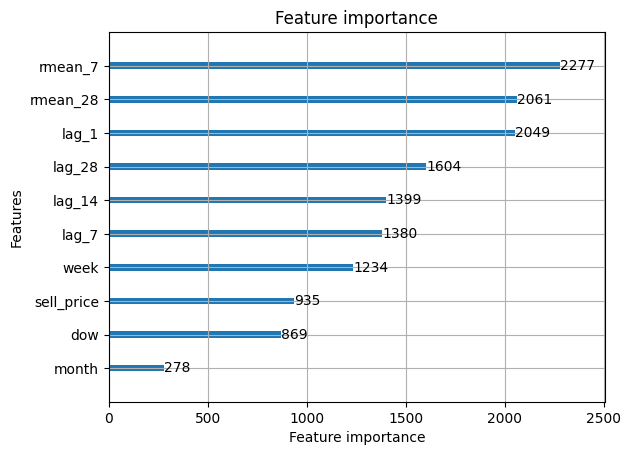

In [10]:
lgb.plot_importance(model, max_num_features=15)


In [11]:
bias = (preds - y_val).mean()
bias


np.float64(-0.0022118251841448306)

In [12]:
wape = (abs(preds - y_val).sum()) / (y_val.sum())
wape


np.float64(0.7542756896695727)